In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
rfm = pd.read_csv("rfm_data.csv")
rfm.head()

,customer_unique_id,last_order_date,recency_days,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114,1,27.19
2,0000f46a3911fa3c0805444483337064,2017-03-10,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288,1,196.89


In [38]:
required_cols = ["customer_unique_id", "recency_days", "frequency", "monetary"]
missing = [c for c in required_cols if c not in rfm.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

#Log transform skewed features

rfm["frequency_log"] = np.log1p(rfm["frequency"])
rfm["monetary_log"]  = np.log1p(rfm["monetary"])

# Recency stays as-is (common practice)
X = rfm[["recency_days", "frequency_log", "monetary_log"]].copy()

# Scales features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:


sil_scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

print("Silhouette scores by k:")
for k, s in sil_scores.items():
    print(f"k={k}: {s:.4f}")

# Choose k:
best_k = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", best_k)


Let's look for elbow method too

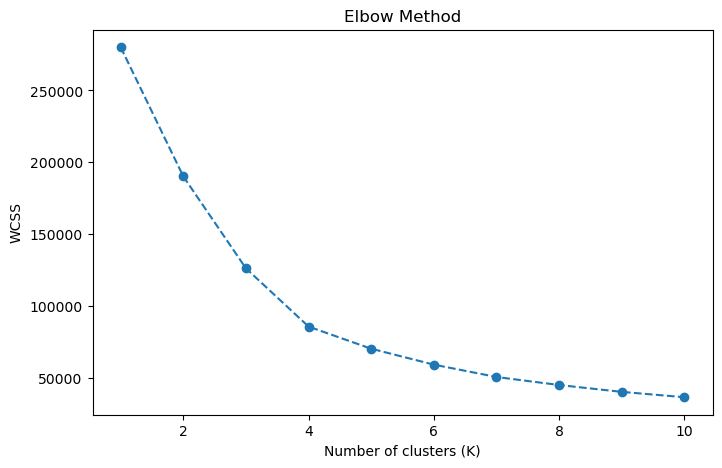

In [6]:
wcss = []
for i in range(1, 11):
    # Initialize KMeans
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Fit to the features
    kmeans.fit(X_scaled)
    # Append the WCSS
    wcss.append(kmeans.inertia_) 

# Plot the results onto a line graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()


While the silhouette score peaked at k=2, this primarily reflected a coarse split between high-value customers and the rest.
The elbow method indicated diminishing returns beyond k=4, and k=4 enabled more actionable customer segments (VIP, Loyal, At-Risk, Low-Value), which aligned better with business objectives.

In [39]:
k = 4

# Initialize KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)

# Fit the model to the data and predict the cluster assignments
rfm["cluster"] = kmeans.fit_predict(X_scaled)

# Create Kmeans cluster profile
k_profile = (
    rfm
    .groupby("cluster")
    .agg(
      customers=("customer_unique_id", "count"),
      avg_recency=("recency_days", "mean"),
      avg_frequency=("frequency", "mean"),
      avg_monetary=("monetary", "mean"),
      total_revenue=("monetary", "sum")
    )
    .reset_index()
)

k_profile['customer_share'] = k_profile['customers'] / k_profile['customers'].sum()
k_profile['revenue_share'] = k_profile['total_revenue'] / k_profile['total_revenue'].sum()


k_profile.sort_values('revenue_share', ascending=False)

k_profile

,cluster,customers,avg_recency,avg_frequency,avg_monetary,total_revenue,customer_share,revenue_share
0,0,26904,425.232716,1.000000,118.741643,3.194625e+06,0.288181,0.207141
1,1,35866,146.889422,1.000000,69.449730,2.490884e+06,0.384177,0.161510
2,2,27787,174.400619,1.000000,319.307423,8.872595e+06,0.297639,0.575303
3,3,2801,219.809354,2.113888,308.588794,8.643572e+05,0.030003,0.056045


We can observe that it is ambiguous to classify the clusters in to four segments: VIP, loyal, at-risk, low value. Instead, I clssifed into three segments: VIP, repeat buyers, and one-time buyers.

In [40]:
# map the segments to the clusters according to the k_profile
clsuter_map = {
  0: 'One-time Buyers',
  1: 'One-time Buyers',
  2: 'VIP',
  3: 'Repeat Buyers'
}
rfm['k3means_segment'] = rfm['cluster'].map(clsuter_map)
rfm

,customer_unique_id,last_order_date,recency_days,frequency,monetary,frequency_log,monetary_log,cluster,k3means_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111,1,141.90,0.693147,4.962145,2,VIP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114,1,27.19,0.693147,3.338967,1,One-time Buyers
2,0000f46a3911fa3c0805444483337064,2017-03-10,537,1,86.22,0.693147,4.468434,0,One-time Buyers
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321,1,43.62,0.693147,3.798182,0,One-time Buyers
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288,1,196.89,0.693147,5.287711,2,VIP
...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,447,1,2067.42,0.693147,7.634540,2,VIP
93354,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,262,1,84.58,0.693147,4.449452,1,One-time Buyers
93355,ffff371b4d645b6ecea244b27531430a,2017-02-07,568,1,112.46,0.693147,4.731450,0,One-time Buyers
93356,ffff5962728ec6157033ef9805bacc48,2018-05-02,119,1,133.69,0.693147,4.902976,2,VIP


In [42]:
# Rebuild the k=3 sgment profile
k3_profile = (
    rfm
    .groupby('k3means_segment')
    .agg(
      customers=("customer_unique_id", "count"),
      avg_recency=("recency_days", "mean"),
      avg_frequency=("frequency", "mean"),
      avg_monetary=("monetary", "mean"),
      total_revenue=("monetary", "sum")
    )
    .reset_index()
)


k3_profile['customer_share'] = k3_profile['customers'] / k3_profile['customers'].sum()
k3_profile['revenue_share'] = k3_profile['total_revenue'] / k3_profile['total_revenue'].sum()


k3_profile

,k3means_segment,customers,avg_recency,avg_frequency,avg_monetary,total_revenue,customer_share,revenue_share
0,One-time Buyers,62770,266.190808,1.000000,90.576855,5.685509e+06,0.672358,0.368651
1,Repeat Buyers,2801,219.809354,2.113888,308.588794,8.643572e+05,0.030003,0.056045
2,VIP,27787,174.400619,1.000000,319.307423,8.872595e+06,0.297639,0.575303


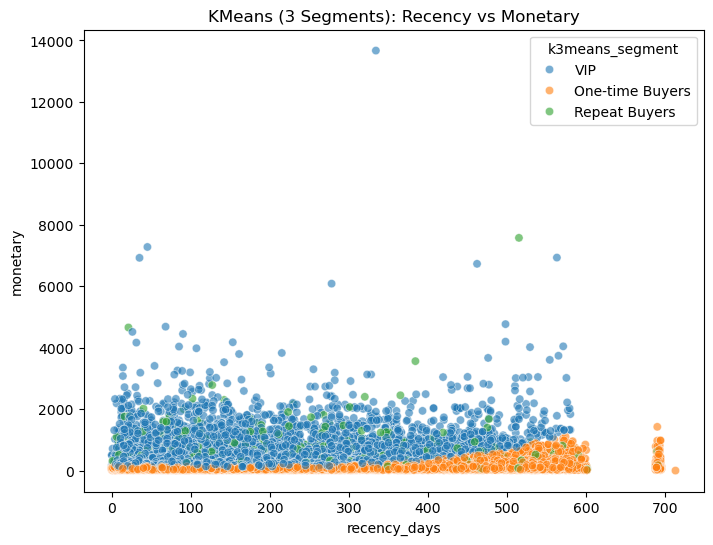

In [45]:

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm,
    x='recency_days',
    y='monetary',
    hue='k3means_segment',
    alpha=0.6
)
plt.title('KMeans (3 Segments): Recency vs Monetary')
plt.show()


While KMeans helped explore the overall customer structure, overlapping clusters limited its direct operational use. I therefore complemented the analysis with a rule-based RFM segmentation, enabling clear and actionable definitions of VIP and At-Risk customers.

In [16]:
rfm_rb = rfm.copy()

# Recency: Reverse the order since lower is better
rfm_rb['R_score'] = pd.qcut(
    rfm_rb['recency_days'],
    4,
    labels=[4, 3, 2, 1]
).astype(int)

# Frequency
rfm_rb['F_score'] = pd.qcut(
    rfm_rb['frequency'].rank(method='first'),
    4,
    labels=[1, 2, 3, 4]
).astype(int)

# Monetary
rfm_rb['M_score'] = pd.qcut(
    rfm_rb['monetary'],
    4,
    labels=[1, 2, 3, 4]
).astype(int)

rfm_rb['RFM_score'] = (
    rfm_rb['R_score'] +
    rfm_rb['F_score'] +
    rfm_rb['M_score']
)

rfm_rb.head()

,customer_unique_id,last_order_date,recency_days,frequency,monetary,frequency_log,monetary_log,cluster,R_score,F_score,M_score,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111,1,141.90,0.693147,4.962145,2,4,1,3,8
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114,1,27.19,0.693147,3.338967,1,4,1,1,6
2,0000f46a3911fa3c0805444483337064,2017-03-10,537,1,86.22,0.693147,4.468434,0,1,1,2,4
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321,1,43.62,0.693147,3.798182,0,2,1,1,4
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288,1,196.89,0.693147,5.287711,2,2,1,4,7


In [25]:

def rfm_segment(row):
    if row['R_score'] >= 4 and row['F_score'] >= 3 and row['M_score'] >= 3:
        return 'VIP'
    elif row['F_score'] >= 3 and row['R_score'] >= 3:
        return 'Loyal'
    elif row['R_score'] <= 2 and row['F_score'] >= 2:
        return 'At-Risk'
    else:
        return 'Low-Value'

rfm_rb['rfm_segment'] = rfm_rb.apply(rfm_segment, axis=1)

# Calculate the profile of each segment
rb_profile = (
    rfm_rb
    .groupby('rfm_segment')
    .agg(
        customers=('customer_unique_id','count'),
        avg_recency=('recency_days','mean'),
        avg_frequency=('frequency','mean'),
        avg_monetary=('monetary','mean'),
        total_revenue=('monetary','sum')
    )
    .reset_index()
)

# Calculate the share of customers and revenue for each segment
rb_profile['customer_share'] = (
    rb_profile['customers'] / rb_profile['customers'].sum()
)

rb_profile['revenue_share'] = (
    rb_profile['total_revenue'] / rb_profile['total_revenue'].sum()
)

rb_profile.sort_values('revenue_share', ascending=False)

rb_profile
rfm_rb.head()

,customer_unique_id,last_order_date,recency_days,frequency,monetary,frequency_log,monetary_log,cluster,R_score,F_score,M_score,RFM_score,rfm_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111,1,141.90,0.693147,4.962145,2,4,1,3,8,Low-Value
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114,1,27.19,0.693147,3.338967,1,4,1,1,6,Low-Value
2,0000f46a3911fa3c0805444483337064,2017-03-10,537,1,86.22,0.693147,4.468434,0,1,1,2,4,Low-Value
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321,1,43.62,0.693147,3.798182,0,2,1,1,4,Low-Value
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288,1,196.89,0.693147,5.287711,2,2,1,4,7,Low-Value
